In [4]:
import os
import json
import requests
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [5]:
# read the data
data = pd.read_csv("../results/inf_outf.csv", index_col=0)
# convert index to datetime
data.index = pd.to_datetime(data.index)

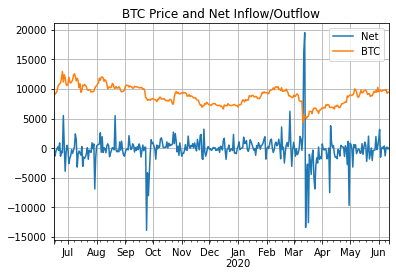

In [6]:
# let's look at inflow/outflow and price
data.drop(columns=["volume", "inflow", "outflow"]).plot()
plt.title("BTC Price and Net Inflow/Outflow")
plt.legend(["Net", "BTC"])
plt.savefig("../plots/btc_inf.png", bbox_inches="tight")
plt.grid(True)

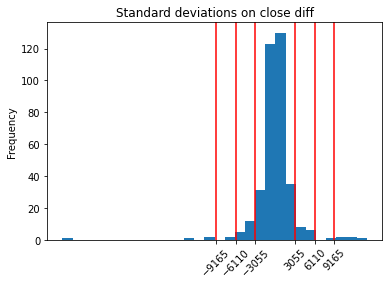

In [7]:
# calculate the daily change
diff = data.net.diff()
# the standard deviation in daily change
s = diff.std()

# let's observe the variances in change in net in/out
diff.plot.hist(bins=30)
for i in range(3):
    plt.axvline(s*(1+i), color='r')
    plt.axvline(s*(-(i+1)), color='r')
    
plt.title("Standard deviations on close diff")
plt.xticks([s*(-(1+i)) for i in reversed(range(3))] + [s*(1+i) for i in range(3)], rotation=45)
#plt.xlim(-20000, 20000)
plt.savefig("../plots/close_diff.png", bbox_inches="tight")
plt.show()

In [8]:
sigma = 3*s      # what we consider anomolous inflow/outflow

# calculating days of large than average net flow
data["net_diff"] = data.net.diff().fillna(0)
data["anom"] = np.where(abs(data.net_diff) > sigma, 1, 0)

print("{:.3f}".format(100*(1-sum(data.anom)/len(data))) + "% non-anomolous days")

97.521% non-anomolous days


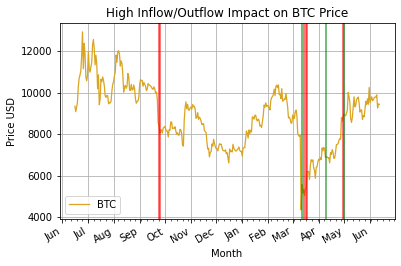

In [9]:
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%b')
weeks = mdates.WeekdayLocator()

fig, ax = plt.subplots()

ax.plot(data.close, color="goldenrod", lw=1.25)

# add the high inflow/outflow days
for i in data.index[data.anom==1]:
    if data.loc[i].net > 0:
        ax.axvline(i, color='g', alpha=0.7)
    else:
        ax.axvline(i, color='r', alpha=0.7)
    
# set the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(weeks)

# add grid
ax.grid(True)
ax.set_title("High Inflow/Outflow Impact on BTC Price")
# format ticks
fig.autofmt_xdate()
ax.legend(["BTC"])
ax.set_ylabel("Price USD")
ax.set_xlabel("Month")
plt.savefig("../plots/high_inf.png", bbox_inches="tight")
plt.show()

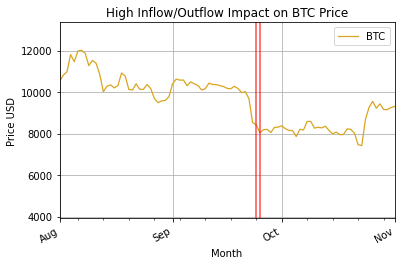

In [10]:
fig, ax = plt.subplots()

ax.plot(data.close, color="goldenrod", lw=1.25)

# add the high inflow/outflow days
for i in data.index[data.anom==1]:
    if data.loc[i].net > 0:
        ax.axvline(i, color='g', alpha=0.7)
    else:
        ax.axvline(i, color='r', alpha=0.7)
    
# set the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(weeks)

# add grid
ax.grid(True)
ax.set_title("High Inflow/Outflow Impact on BTC Price")
# format ticks
fig.autofmt_xdate()
ax.legend(["BTC"])
ax.set_ylabel("Price USD")
ax.set_xlabel("Month")
plt.xlim(datetime.date(2019, 8, 1), datetime.date(2019, 11, 1))
plt.savefig("../plots/first.png", bbox_inches="tight")
plt.show()

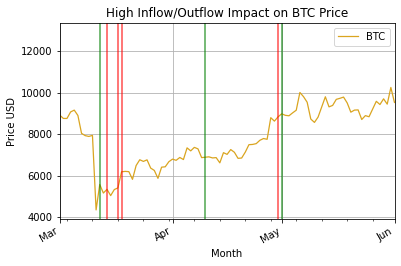

In [11]:
fig, ax = plt.subplots()

ax.plot(data.close, color="goldenrod", lw=1.25)

# add the high inflow/outflow days
for i in data.index[data.anom==1]:
    if data.loc[i].net > 0:
        ax.axvline(i, color='g', alpha=0.7)
    else:
        ax.axvline(i, color='r', alpha=0.7)
    
# set the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(weeks)

# add grid
ax.grid(True)
ax.set_title("High Inflow/Outflow Impact on BTC Price")
# format ticks
fig.autofmt_xdate()
ax.legend(["BTC"])
ax.set_ylabel("Price USD")
ax.set_xlabel("Month")
plt.xlim(datetime.date(2020, 3, 1), datetime.date(2020, 6, 1))
plt.savefig("../plots/second.png", bbox_inches="tight")
plt.show()

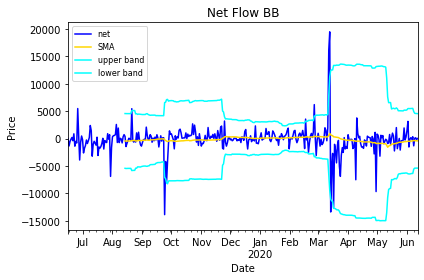

In [22]:
def bollinger_bands(df,lookback,std,plot='no'):
    sym = list(df.columns.values)[0]
    rolling_mean = df.rolling(window=lookback,center=False).mean()
    rolling_std = df.rolling(window=lookback,center=False).std()
    upper_band = rolling_mean + std*rolling_std
    lower_band = rolling_mean - std*rolling_std
    lower_band.rename(columns={sym:'lower band'}, inplace=True)
    upper_band.rename(columns={sym:'upper band'}, inplace=True)
    rolling_mean.rename(columns={sym:'SMA'}, inplace=True)

    if plot == 'yes':
        ax = df.plot(title="Net Flow BB", label=sym,color = 'blue')
        rolling_mean.plot(ax=ax, color='gold')
        upper_band.plot(ax=ax, color = 'cyan')
        lower_band.plot(ax=ax, color = 'cyan')
        ax.set_xlabel("Date")
        ax.set_ylabel("Price")
        ax.legend(loc='upper left', prop={'size':8})
        plt.tight_layout()
        plt.savefig("../plots/"+sym+'_BollingerBands.png')
        plt.show()
    return rolling_mean,upper_band,lower_band

rolling_mean, upper, lower = bollinger_bands(data[["net"]], lookback=60, std=3, plot="yes")

In [13]:
data["rolling_mean"] = rolling_mean
data["upper"] = upper
data["lower"] = lower

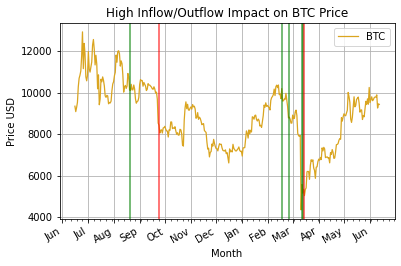

In [14]:
fig, ax = plt.subplots()

ax.plot(data.close, color="goldenrod", lw=1.25)

# add the high inflow/outflow days
for i in data.index[data.net > data.upper]:
    ax.axvline(i, color='g', alpha=0.7)
for i in data.index[data.net < data.lower]:
    ax.axvline(i, color='r', alpha=0.7)
    
# set the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(weeks)

# add grid
ax.grid(True)
ax.set_title("High Inflow/Outflow Impact on BTC Price")
# format ticks
fig.autofmt_xdate()
ax.legend(["BTC"])
ax.set_ylabel("Price USD")
ax.set_xlabel("Month")
plt.savefig("../plots/overall_bb.png", bbox_inches="tight")
plt.show()

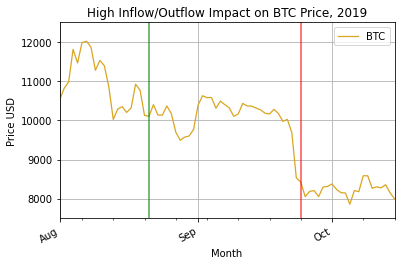

In [15]:
fig, ax = plt.subplots()

ax.plot(data.close, color="goldenrod", lw=1.25)

# add the high inflow/outflow days
for i in data.index[data.net > data.upper]:
    ax.axvline(i, color='g', alpha=0.7)
for i in data.index[data.net < data.lower]:
    ax.axvline(i, color='r', alpha=0.7)
    
# set the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(weeks)

# add grid
ax.grid(True)
ax.set_title("High Inflow/Outflow Impact on BTC Price, 2019")
# format ticks
fig.autofmt_xdate()
ax.legend(["BTC"])
ax.set_ylabel("Price USD")
ax.set_xlabel("Month")
plt.xlim(datetime.date(2019, 8, 1), datetime.date(2019, 10, 15))
plt.ylim(7500, 12500)
plt.savefig("../plots/bb_first.png", bbox_inches="tight")
plt.show()

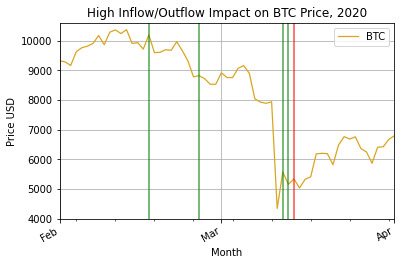

In [16]:
fig, ax = plt.subplots()

ax.plot(data.close, color="goldenrod", lw=1.25)

# add the high inflow/outflow days
for i in data.index[data.net > data.upper]:
    ax.axvline(i, color='g', alpha=0.7)
for i in data.index[data.net < data.lower]:
    ax.axvline(i, color='r', alpha=0.7)
    
# set the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(weeks)

# add grid
ax.grid(True)
ax.set_title("High Inflow/Outflow Impact on BTC Price, 2020")
# format ticks
fig.autofmt_xdate()
ax.legend(["BTC"])
ax.set_ylabel("Price USD")
ax.set_xlabel("Month")
plt.xlim(datetime.date(2020, 2, 1), datetime.date(2020, 4, 1))
plt.ylim(4000, 10600)
plt.savefig("../plots/bb_second.png", bbox_inches="tight")
plt.show()

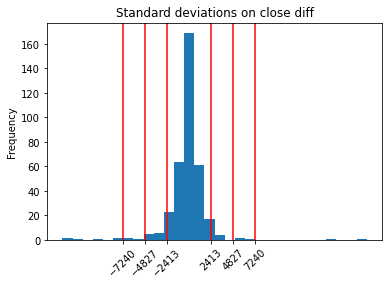

In [17]:
# calculate the daily change
diff = data.net
# the standard deviation in daily change
s = diff.std()

# let's observe the variances in change in net in/out
diff.plot.hist(bins=30)
for i in range(3):
    plt.axvline(s*(1+i), color='r')
    plt.axvline(s*(-(i+1)), color='r')
    
plt.title("Standard deviations on close diff")
plt.xticks([s*(-(1+i)) for i in reversed(range(3))] + [s*(1+i) for i in range(3)], rotation=45)
plt.savefig("../plots/std_dev.png", bbox_inches="tight")
plt.show()

In [18]:
sigma = 3*s      # what we consider anomolous inflow/outflow

# calculating days of large than average net flow
data["anom"] = np.where(abs(data.net) > sigma, 1, 0)

print("{:.3f}".format(100*(1-sum(data.anom)/len(data))) + "% non-anomolous days")

97.796% non-anomolous days


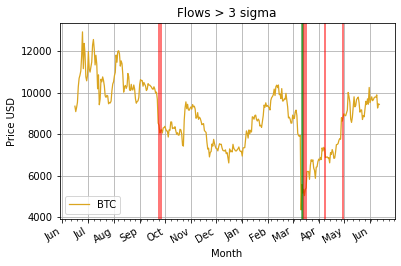

In [19]:
fig, ax = plt.subplots()

ax.plot(data.close, color="goldenrod", lw=1.25)

# add the high inflow/outflow days
for i in data.index[data.anom==1]:
    if data.loc[i].net > 0:
        ax.axvline(i, color='g', alpha=0.7)
    else:
        ax.axvline(i, color='r', alpha=0.7)
    
# set the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(weeks)

# add grid
ax.grid(True)
ax.set_title("Flows > 3 sigma")
# format ticks
fig.autofmt_xdate()
ax.legend(["BTC"])
ax.set_ylabel("Price USD")
ax.set_xlabel("Month")
plt.savefig("../plots/3_sigma.png", bbox_inches="tight")
plt.show()

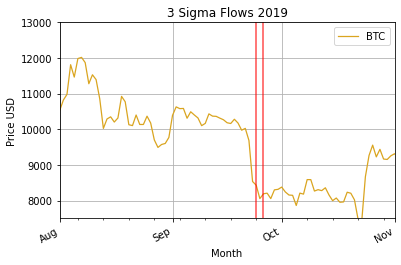

In [20]:
fig, ax = plt.subplots()

ax.plot(data.close, color="goldenrod", lw=1.25)

# add the high inflow/outflow days
for i in data.index[data.anom==1]:
    if data.loc[i].net > 0:
        ax.axvline(i, color='g', alpha=0.7)
    else:
        ax.axvline(i, color='r', alpha=0.7)
    
# set the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(weeks)

# add grid
ax.grid(True)
ax.set_title("3 Sigma Flows 2019")
# format ticks
fig.autofmt_xdate()
ax.legend(["BTC"])
ax.set_ylabel("Price USD")
ax.set_xlabel("Month")
plt.xlim(datetime.date(2019, 8, 1), datetime.date(2019, 11, 1))
plt.ylim(7500, 13000)
plt.savefig("../plots/3_sigma_2019.png", bbox_inches="tight")
plt.show()

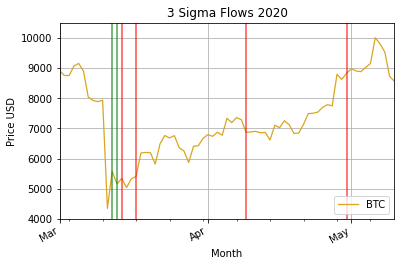

In [21]:
fig, ax = plt.subplots()

ax.plot(data.close, color="goldenrod", lw=1.25)

# add the high inflow/outflow days
for i in data.index[data.anom==1]:
    if data.loc[i].net > 0:
        ax.axvline(i, color='g', alpha=0.7)
    else:
        ax.axvline(i, color='r', alpha=0.7)
    
# set the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(weeks)

# add grid
ax.grid(True)
ax.set_title("3 Sigma Flows 2020")
# format ticks
fig.autofmt_xdate()
ax.legend(["BTC"])
ax.set_ylabel("Price USD")
ax.set_xlabel("Month")
plt.xlim(datetime.date(2020, 3, 1), datetime.date(2020, 5, 10))
plt.ylim(4000, 10500)
plt.savefig("../plots/3_sigma_2020.png", bbox_inches="tight")
plt.show()

## Looking for Whales

In [21]:
with open("../results/tot_activity.json", "r") as f:
    inp = f.read()
    
act = json.loads(inp)

In [22]:
def format_activity(d):
    d = json.loads(d)
    df = pd.DataFrame(d).reset_index()
    time = pd.to_numeric(df["index"])
    df.index = [datetime.datetime.fromtimestamp(t//10**3) for t in time]
    df = df.drop(["index"], axis=1)
    return df

In [23]:
all_activity = {key: format_activity(val) for key, val in act.items() if val}

In [24]:
infs, outfs = [0]*len(all_activity.keys()), [0]*len(all_activity.keys())
i = 0

for key, val in all_activity.items():
    infs[i] = val.inflow.sum()
    outfs[i] = val.outflow.sum()
    i += 1

In [29]:
tot_flows = pd.DataFrame({"inf_tot":infs, "outf_tot":outfs}, index=all_activity.keys())

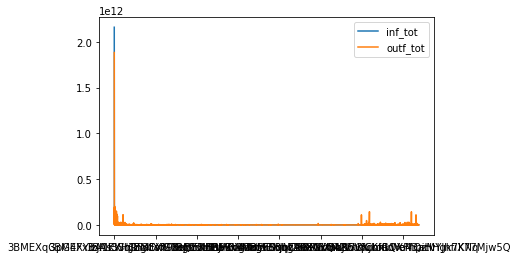

In [30]:
tot_flows.sort_values(by=["inf_tot"], ascending=False).plot()

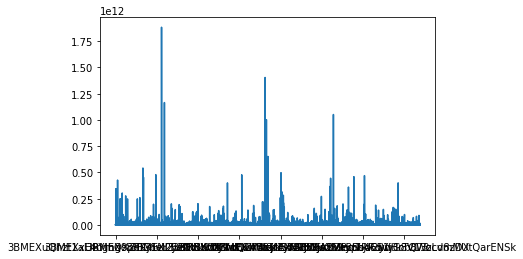

In [31]:
tot_flows["outf_tot"].plot()

### BitMEX vs BMEX

In [66]:
bitMEX = tot_flows[tot_flows.index.str.startswith("3BitMEX")]
bMEX = tot_flows[tot_flows.index.str.startswith("3BMEX")]
print(f"Number of active 3BMEX addresses: {len(bMEX)}")
print(f"Number of active 3BitMEX addresses: {len(bitMEX)}")
print(f"Average Outflow of active 3BMEX addresses: {bMEX.outf_tot.mean()/10**8}")
print(f"Average Inflow of active 3BitMEX addresses: {bitMEX.outf_tot.mean()/10**8}")

Number of active 3BMEX addresses: 184298
Number of active 3BitMEX addresses: 59
Average Outflow of active 3BMEX addresses: 4.9583523130652525
Average Inflow of active 3BitMEX addresses: 6.10844364559322
